In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from PIL import Image
import matplotlib.font_manager as fm
from datetime import datetime
!pip install konlpy
from konlpy.tag import Okt
import re

In [ ]:
# 경기 및 티켓 및 고객 데이터
df_tk = pd.read_csv('/content/drive/MyDrive/project_cp2/reserve_ticket_202211221456.csv')
df_sv = pd.read_csv('/content/drive/MyDrive/project_cp2/survey_complete_.csv')
df_mb = pd.read_csv('/content/drive/MyDrive/project_cp2/membership_202211221455.csv')
df_gm = pd.read_csv('/content/drive/MyDrive/project_cp2/game_list.csv')

In [ ]:
# 고객 설문조사 데이터
df_sv1 = pd.read_csv('/content/drive/MyDrive/project_cp2/survey_result_.csv')
df_sv2 = pd.read_csv('/content/drive/MyDrive/project_cp2/survey_main_.csv')
df_sv3 = pd.read_csv('/content/drive/MyDrive/project_cp2/survey_item_.csv')

In [ ]:
# 날씨의 영향을 구분하기위한 날씨데이터
df_wt = pd.read_csv('/content/drive/MyDrive/OBS_ASOS_DD_20241008012838.csv', encoding='cp949')

In [ ]:
# 폰트 경로 설정
font_path = '/content/drive/My Drive/GULIM.TTC'

# 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='Gulim')

In [ ]:
# 날씨데이터와 경기데이터의 지역을 맞춰줌
def namechange(x):
  if x == '서귀포':
    return '제주w'
  if x == '수원':
    return '수원'
  if x == '울산':
    return '문수'
  if x == '대구':
    return '대구전'
  if x == '전주':
    return '전주w'
  if x == '인천':
    return '인천'
  if x == '서울':
    return '서울w'
  if x == '구미':
    return '김천'
  if x == '춘천':
    return '춘천'
  if x == '강릉':
    return '강릉'
  if x == '포항':
    return '포항'
  if x == '광주':
    return '광주'

df_wt['지점명'] = df_wt.지점명.apply(namechange)
df_wt = df_wt.drop(['지점'], axis=1)
df_gm.loc[df_gm['field_name'] == '수원w', 'field_name'] = '수원'
df_gm.loc[df_gm['field_name'] == '탄천', 'field_name'] = '수원'

In [ ]:
df_gm = df_gm.drop(['no_seq','preview','review','game_date_timestamp','game_code','home_team','home_team_name','game_id','meet_name','meet_seq','meet_year','home_team_tk','away_team_tk','game_type_name','game_type','field_id','away_team','away_team_name'], axis=1)

In [ ]:
# 날씨데이터와 게임데이터와 티켓데이터 병합
df_wt = df_wt.fillna(0) # 강수량, 적설량 nan 데이터는 비, 눈이 안왔다는 뜻
df_wt = df_wt.drop(['일 최심적설(cm)'],axis=1) # 경기중에 눈이 오는날은 없었음
df_wt['일시'] = df_wt['일시'].apply(lambda _ : datetime.strptime(_,'%Y-%m-%d'))
df_wt.rename(columns={'일시':'game_date'}, inplace = True)
df_gm['game_date'] = df_gm['game_date'].apply(lambda _ : datetime.strptime(_,'%Y/%m/%d'))
df_gm = df_gm.drop(['game_time'],axis=1)
df_gm1 = pd.merge(df_wt,df_gm,on='game_date',how='inner').fillna(0)
df_gm1 = df_gm1[df_gm1['지점명'] == df_gm1['field_name']]
df_tk['game_date'] = df_tk['game_date'].apply(lambda _ : datetime.strptime(_,'%Y-%m-%d'))
# df_gm에 fc광주전 관중수 누락으로, df_tk fc광주전 데이터 삭제
df_tk = df_tk[df_tk['game_date'] != '2022-04-27']
df_tk = df_tk.drop(['idx','reserve_no','reserve_datetime','cancel_datetime','match_info','ticket_no','seat_Attribute_4','seat_Attribute_6','detail_cancel_date_time','cancel_yn','seat_Attribute_5'],axis=1)

In [ ]:
# 티켓데이터의 좌석상세정보 삭제 및 좌석 가격 분류
df_tk = df_tk.replace(to_replace={'product_grade_name' : {'S석':'NSE석','Expert석':'NSE석','1인 테이블석(EG4)':'테이블석','1인 테이블석(EG1)':'테이블석','서비푸드 테이블석(EG4)':'테이블석','Wide view석':'World class석',
                                                  '1인 테이블석EG4)':'테이블석','1인 테이블석(SG2)':'테이블석','N석':'NSE석','서비푸드 테이블석(EG1)':'테이블석','서비푸드 테이블석(SG2)':'테이블석','피크닉 테이블석(2인)':'테이블석',
                                                  'S 지정석':'NSE석','W 지정석':'NSE석','E/N/S 자유석':'NSE석','W 지정석(1층)':'NSE석','E 지정석(1층)':'NSE석','W 지정석(2층)':'NSE석','E 지정석(2층)':'NSE석','E 지정석':'NSE석',
                                                  'N 지정석':'NSE석','W 자유석':'NSE석','게임권':'NSE석','2게임권':'NSE석','W 지정석(휠체어석)':'NSE석','E 지정석(휠체어석)':'NSE석', '프리미엄 클래식':'프리미엄석',
                                                  '프리미엄 골드':'프리미엄석','프리미엄 클래식':'프리미엄석','프리미엄':'프리미엄석','스카이박스':'프리미엄석','프리미엄 클래식':'프리미엄석','With석':'World class석',
                                                  '하이네켄 테이블석(2인)':'테이블석','피크닉 테이블석':'테이블석','하이트 테이블석':'테이블석','하이네켄 테이블석':'테이블석','Exciting석':'NSE석','원정석':'NSE석',
                                                  '하이트 테이블석(시즌권 할인)':'테이블석','피크닉 테이블석(시즌권 할인)':'테이블석','스카이라운지(시즌권 할인)':'프리미엄석','스카이라운지':'프리미엄석','집관티켓':'NSE석'
                                                   }})

In [ ]:
# 결제 수단 정리
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("에스코트 패키지","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("휠체어석 성인","성인")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("10% 할인쿠폰(청소년/어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("W 성인 3게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("W 청소년 4게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("W 청소년시즌권 업그레이드","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("주주초청경기(청소년)","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("E/N/S 청소년 4게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("동반인(청소년/어린이)","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("휠체어석 청소년/어린이","청소년/어린이")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("3게임권(청소년)","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("어린이(특별할인50%)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("W 성인 2게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("ENS석 성인","성인")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("W석 성인","성인")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("2게임권(청소년)","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("W 성인 4게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("5vs5배틀비어(맥주빨리마시기)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("E/N/S 청소년 2게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("4게임권(청소년)","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("E/N/S 청소년 3게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("동반인(성인)","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("10% 할인쿠폰(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("10% 할인쿠폰","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("주주초청경기(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("E/N/S 성인 2게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("프리미엄 시즌권 업그레이드","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("성인/청소년","성인")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("동행인","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("어린이 시즌권 동반(청소년)","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("E/N/S 성인 3게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("W 성인시즌권 업그레이드","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("주주초청경경기(어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("경기별 할인권(10%)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("2게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("3게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("E/N/S 성인 4게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("K리그패스","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("4게임권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("광석 is strong! 집관티켓","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("연수 is strong! 집관티켓","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("하이네켄 X 집관티켓","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("한가위 랜덤박스 집관티켓","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("집관티켓","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("경기별 할인권(30%)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("4인가족권","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("3인가족권","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("어린이 시즌권 동반(어린이)","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("청소년(특별할인50%)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("성인(특별할인50%)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("E/N/S 성인시즌권 업그레이드","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("예매권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("시즌권 예매권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("어린이 시즌권 동반(성인)","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("2인가족권","가족")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("일반","성인")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("어린이(예매)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("청소년(예매)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("일반(할인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("성인(예매)","성인")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("포스코 건설 예매권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("셀트리온 예매권","예매권북")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("성인/청소년/어린이","일반")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("K리그 축덕카드(체크)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("문화누리카드(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("K리그 축덕카드(신용)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("5,000포인트 할인 쿠폰(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("5천원 멤버십 할인권 (성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("5,000포인트 할인 쿠폰(청소년/어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("ㅅㅇ전 게임권","일반")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("5천원 멤버십 할인권(청소년/어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("K리그 PASS","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("3,000포인트 할인 쿠폰(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("게임권","일반")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("청소년","청소년/어린이")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("5천원 멤버십 할인권 (일반)","일반(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("3,000포인트 할인 쿠폰(청소년/어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("N회 방문자 할인쿠폰","일반(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("어린이","청소년/어린이")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("프리미엄 골드석 50% 할인쿠폰","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("롯데백화점 30% 할인쿠폰(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("3,000포인트 할인 쿠폰(일반)","일반(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("1인 테이블석 할인권","일반(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("5,000포인트 할인 쿠폰(일반)","일반(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("1,000포인트 할인 쿠폰(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("1,000포인트 할인 쿠폰(청소년/어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("1인 테이블석 50% 할인쿠폰","일반(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("1,000포인트 할인 쿠폰(일반)","일반(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("1만원 멤버십 할인권 (청소년/어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("생일쿠폰(청소년/어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("1만원 멤버십 할인권 (성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("생일쿠폰(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("10% 할인 쿠폰(성인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("10% 할인 쿠폰(청소년/어린이)","청소년/어린이(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("일반","성인")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("일반(할인)","성인(할인)")
df_tk['product_denomination_name'] = df_tk['product_denomination_name'].replace("예매권북","멤버쉽")


In [ ]:
# 경기결과 열 생성 후 승:1, 패:-1, 무승부:0 저장
def score_result(row):
 if row['지점명'] == '인천':
  if row['home_team_goal'] > row['away_team_goal']:
    return 1
  elif row['home_team_goal'] < row['away_team_goal']:
    return -1
  else :
    return 0
 else :
  if row['home_team_goal'] > row['away_team_goal']:
    return -1
  elif row['home_team_goal'] < row['away_team_goal']:
    return 1
  else :
    return 0

df_gm1['score'] = df_gm1.apply(score_result, axis=1)
df_gm1 = df_gm1.drop(['home_team_goal','away_team_goal'],axis=1)

In [ ]:
# 고객 정보 정리 df_mb
df_mb['job'] = df_mb['job'].replace("회사원(사무직/연구직)","회사원")
df_mb['job'] = df_mb['job'].replace("회사원(제조/건설/기술직)","회사원")
df_mb['job'] = df_mb['job'].replace("자영업자","프리랜서")
df_mb['job'] = df_mb['job'].replace("프리랜서","프리랜서")
df_mb['job'] = df_mb['job'].replace("서비스업 종사자","회사원")
df_mb['job'] = df_mb['job'].replace("교사","회사원")
df_mb['job'] = df_mb['job'].replace("공무원","회사원")
df_mb['job'] = df_mb['job'].replace("보건 및 의료종사자","회사원")
df_mb['job'] = df_mb['job'].replace("금융 및 보험업 종사자","회사원")
df_mb['job'] = df_mb['job'].replace("군인(소방/경찰/교정직 포함)","회사원")
df_mb['job'] = df_mb['job'].replace("예술 및 디자인 종사자","회사원")
df_mb['job'] = df_mb['job'].replace("방송 및 언론 종사자","회사원")
df_mb['job'] = df_mb['job'].replace("법률 종사자","회사원")
df_mb['job'] = df_mb['job'].replace("농업 종사자(축산/수산/임업 포함)","회사원")
df_mb['job'] = df_mb['job'].replace("학생(초/중/고)","학생")
df_mb['job'] = df_mb['job'].replace("대학생(대학원생 포함)","학생")
df_mb['job'] = df_mb['job'].replace("전업주부","무직")
df_mb['job'] = df_mb['job'].replace("무직","무직")
df_mb['job'] = df_mb['job'].fillna('기타')

In [ ]:
# 고객 나이 열 생성
df_mb['age'] = 2022 - df_mb['MB_AGE']
df_mb = df_mb.drop(['MB_AGE','zipcode'],axis=1)

In [ ]:
df_gmtk = pd.merge(df_gm1,df_tk,on='game_date',how='outer')
df_mb.rename(columns = {'MB_IDX':'membership_no'},inplace = True)
df_gbk = pd.merge(df_mb,df_gmtk,how = 'inner', on = 'membership_no')

In [ ]:
# 21년까지 코로나 사태 관련으로 1년 정상적으로 리그가 진행된 22년의 데이터를 중심으로 파악
df_2022 = df_gbk.loc[df_gbk["game_date"].dt.year == 2022]

In [ ]:
# 설문조사 sv1, sv2, sv3 데이터 병합
df_sv2 = df_sv2.drop(['subject','description'],axis=1)
df_sv2.rename(columns = {'idx':'survey_idx'},inplace = True)
df_sv23 = pd.merge(df_sv2,df_sv3,how = 'inner', on = 'survey_idx')
df_sv23.rename(columns = {'idx':'survey_item_idx'},inplace = True)
df_sv123 = pd.merge(df_sv1,df_sv23)

In [ ]:
# 점수형 문항에서 직업 비율로 사용할 데이터 분류
df_sv['job'] = df_sv['job'].replace("회사원(사무직/연구직)","회사원")
df_sv['job'] = df_sv['job'].replace("회사원(제조/건설/기술직)","회사원")
df_sv['job'] = df_sv['job'].replace("교사","회사원")
df_sv['job'] = df_sv['job'].replace("서비스업 종사자","회사원")
df_sv['job'] = df_sv['job'].replace("공무원","회사원")
df_sv['job'] = df_sv['job'].replace("보건 및 의료종사자","회사원")
df_sv['job'] = df_sv['job'].replace("금융 및 보험업 종사자","회사원")
df_sv['job'] = df_sv['job'].replace("군인(소방/경찰/교정직 포함)","회사원")
df_sv['job'] = df_sv['job'].replace("예술 및 디자인 종사자","회사원")
df_sv['job'] = df_sv['job'].replace("방송 및 언론 종사자","회사원")
df_sv['job'] = df_sv['job'].replace("법률 종사자","회사원")
df_sv['job'] = df_sv['job'].replace("농업 종사자(축산/수산/임업 포함)","회사원")
df_sv['job'] = df_sv['job'].replace("전업주부","무직")
df_sv['job'] = df_sv['job'].replace("자영업자","프리랜서")
df_sv['job'] = df_sv['job'].replace("대학생(대학원생 포함)","학생")
df_sv['job'] = df_sv['job'].replace("학생(초/중/고","학생")

In [ ]:
# 나이 열 생성
df_sv['start_date'] = df_sv['start_date'].apply(lambda _: datetime.strptime(_, '%Y-%m-%d %H:%M:%S'))
df_sv['year'] = df_sv['start_date'].dt.year
df_sv['age'] = df_sv['year'] - df_sv['MB_AGE']
df_sv = df_sv.drop(['MB_IDX','MB_AGE','year','start_date','end_date','zipcode','survey_idx','favorite_idx','state'],axis=1)
df_sv.rename(columns = {'idx':'survey_target_idx'},inplace = True)

In [ ]:
df_svy = pd.merge(df_sv123,df_sv,how = 'inner', on = 'survey_target_idx')

In [ ]:
# 제품광고 및 주제와 관련없는 문항 삭제
df_svy['item_text'] = df_svy['item_text'].str.strip()
values_to_keep1 = ['매우 만족 #만족 #보통 #불만족 #매우 불만족','10점(매우추천) #9점 #8점 #7점 #6점 #5점 #4점 #3점 #2점 #1점 #0점(추천안함)','매우 만족 #만족 #보통 #불만족 #매우 불만족 #미방문',
                  '매우좋음 #좋음 #보통 #나쁨 #매우나쁨','0점(추천안함) #1점 #2점 #3점 #4점 #5점 #6점 #7점 #8점 #9점 #10점(매우추천)','매우많다 #많다 #보통 #적다 #매우적다',
                  '매우있음 #있음 #보통 #없음 #매우없음','매우 그렇다 #그렇다 #보통 #그렇지 않다 #매우 그렇지 않다','매우만족 #만족 #보통 #불만족 #매우불만족',
                  '미방문 #매우 만족 #만족 #보통 #불만족 #매우 불만족','매우 좋았다 #좋았다 #보통 #좋지 않았다 #매우 좋지 않다 #구매하지 않음','매우비쌈 #비쌈 #적정 #저렴 #매우저렴',
                  '매우 비쌈 #비쌈 #적정 #저렴 #매우 저렴','매우 그렇다 #그렇다 #보통 #그렇지 않다 #매우 그렇지 않다 #구매하지 않음',
                  '매우 그렇다 #그렇다 #보통 #그렇지 않다 #매우 그렇지 않다 #먹어보지 않았다','매우그렇다 #그렇다 #보통 #그렇지않다 #매우그렇지않다'
]
values_to_keep2 = ['하이네켄 0.0(논알콜 맥주)의 맛이 좋았다.','하이네켄 0.0(논알콜 맥주) 제품을 앞으로 경기장에서 드실 의향이 있으신가요?','하이네켄을 구매하신 후 지불한 금액만큼 가치가 있었나요?',
                   '하이네켄의 맛은 어떠셨나요?','하이네켄이 인천 스폰서가 되면서 친숙하게 느끼게 되셨나요?','맥주 구매 시 하이네켄이 보이면 스폰서이기 때문에 구매하려고 한 적이 있으신가요?']

df_svym = df_svy[df_svy['item_text'].isin(values_to_keep1)]
df_svym = df_svym[~df_svym['subject'].isin(values_to_keep2)]

In [ ]:
df_svym

,idx,survey_target_idx,survey_item_idx,answer_index,answer_content,survey_idx,order_seq,subject,item_type,item_text,item_number,required_yn,job,age
5,115,525,119,1,좋음,24,5,2020 시즌권 가격의 적정성,M,매우좋음 #좋음 #보통 #나쁨 #매우나쁨,0.0,Y,학생,21
6,116,525,120,1,좋음,24,6,2020 시즌권 구성의 만족도,M,매우좋음 #좋음 #보통 #나쁨 #매우나쁨,0.0,Y,학생,21
7,117,525,121,0,매우좋음,24,7,2020 시즌권 환불의 적정성,M,매우좋음 #좋음 #보통 #나쁨 #매우나쁨,0.0,Y,학생,21
9,119,525,123,0,매우있음,24,9,2021 시즌권 구매 의사,M,매우있음 #있음 #보통 #없음 #매우없음,0.0,Y,학생,21
10,120,525,124,1,많다,24,10,2021 시즌권 구매 시 코로나19 확산세의 영향은?,M,매우많다 #많다 #보통 #적다 #매우적다,0.0,Y,학생,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95579,104005,50071,1593,0,매우 만족,134,5,티켓 발권 및 예매에 대한 만족도 평가입니다.,M,매우 만족 #만족 #보통 #불만족 #매우 불만족,0.0,Y,회사원,35
95580,104006,50071,1594,0,매우 만족,134,6,금일 경기장 입장 게이트 운영에 대한 만족도 평가입니다.,M,매우 만족 #만족 #보통 #불만족 #매우 불만족,0.0,Y,회사원,35
95583,104009,50071,1597,0,매우 만족,134,9,금일 이용하신 좌석에 대한 만족도를 평가해주십시오.,M,매우 만족 #만족 #보통 #불만족 #매우 불만족,0.0,Y,회사원,35
95588,104014,50071,1600,5,미방문,134,12,블루마켓(MD샵)에 대한 만족도 평가입니다.,M,매우 만족 #만족 #보통 #불만족 #매우 불만족 #미방문,0.0,Y,회사원,35


In [ ]:
# df_svym 설문조사 수치화
df_svym['answer_content'] = df_svym['answer_content'].str.strip().astype(str)
df_svym['answer_content'] = df_svym['answer_content'].replace(to_replace={
    '매우 만족': 10,
    '만족': 8,
    '보통': 6,
    '불만족': 4,
    '매우 불만족': 1,
    '미방문': np.nan,
    '10점(매우추천)': 10,
    '9점': 9,
    '8점': 8,
    '7점': 7,
    '6점': 6,
    '5점': 5,
    '4점': 4,
    '3점': 3,
    '2점': 2,
    '1점': 1,
    '0점(추천안함)': 0,
    '매우좋음': 10,
    '좋음': 8,
    '적정': 6,
    '나쁨': 4,
    '매우나쁨': 1,
    '매우있음': 10,
    '있음': 8,
    '없음': 4,
    '매우없음': 1,
    '매우적다': 1,
    '많다': 8,
    '적다': 4,
    '매우많다': 10,
    '매우만족': 10,
    '매우그렇다': 10,
    '그렇다': 8,
    '매우불만족': 1,
    '매우 비쌈' : 1,
    '매우비쌈': 1,
    '매우저렴': 10,
    '저렴': 8,
    '비쌈': 4,
})

# 수치화된 값이 있는 행만 int로 변환
df_svym['answer_content'] = df_svym['answer_content'].apply(lambda x: int(x) if isinstance(x, (int, float)) and not pd.isna(x) else x)

# 숫자만 있는 행 추출
df_svja = df_svym[df_svym['answer_content'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x))][['answer_content','job', 'age']]
df_svja['job'] = df_svja['job'].fillna('기타')
df_svja['answer_content'] = df_svja['answer_content'].astype(int)
df_svja.reset_index(drop=True, inplace=True)

# df_svja 이용해서 직업과 나이에따른 설문조사 호감도 파악
# 직업에 따른 호감도는 차이없음, 나이에따른 호감도 차이없음

In [ ]:
df_svja

,answer_content,job,age
0,8,학생,21
1,8,학생,21
2,10,학생,21
3,10,학생,21
4,8,학생,21
...,...,...,...
26714,10,기타,40
26715,10,회사원,35
26716,10,회사원,35
26717,10,회사원,35


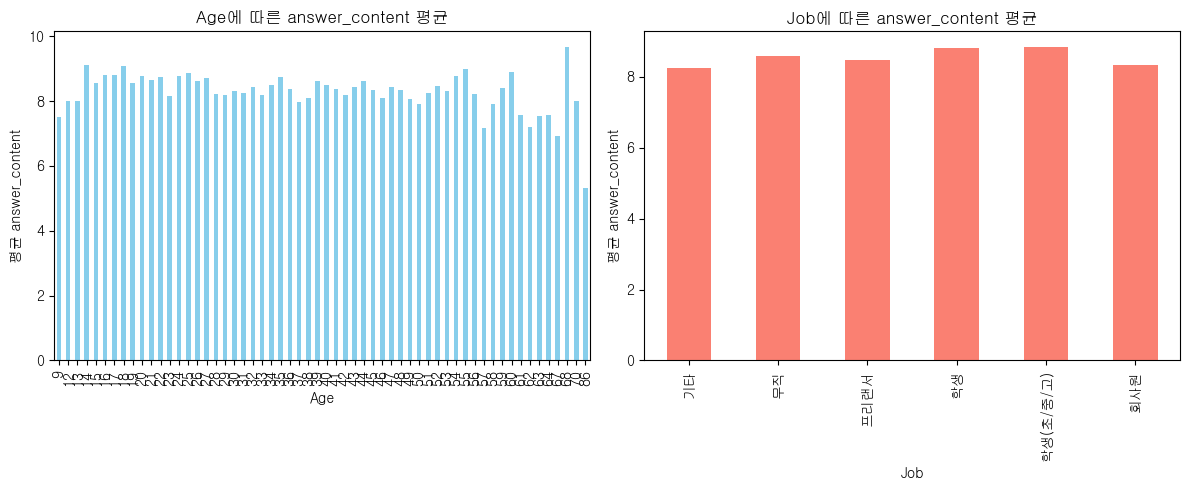

In [ ]:
# age에 따른 answer_content 평균
age_mean = df_svja.groupby('age')['answer_content'].mean()

# job에 따른 answer_content 평균
job_mean = df_svja.groupby('job')['answer_content'].mean()

plt.figure(figsize=(12, 5))

# age에 따른 평균 그래프
plt.subplot(1, 2, 1)
age_mean.plot(kind='bar', color='skyblue')
plt.title('Age에 따른 answer_content 평균')
plt.xlabel('Age')
plt.ylabel('평균 answer_content')

# job에 따른 평균 그래프
plt.subplot(1, 2, 2)
job_mean.plot(kind='bar', color='salmon')
plt.title('Job에 따른 answer_content 평균')
plt.xlabel('Job')
plt.ylabel('평균 answer_content')

plt.tight_layout()
plt.show()

<ipython-input-123-79be399269f6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_under_30.loc[:, 'processed_content'] = df_under_30['answer_content'].apply(preprocess_text)
<ipython-input-123-79be399269f6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_30.loc[:, 'processed_content'] = df_over_30['answer_content'].apply(preprocess_text)


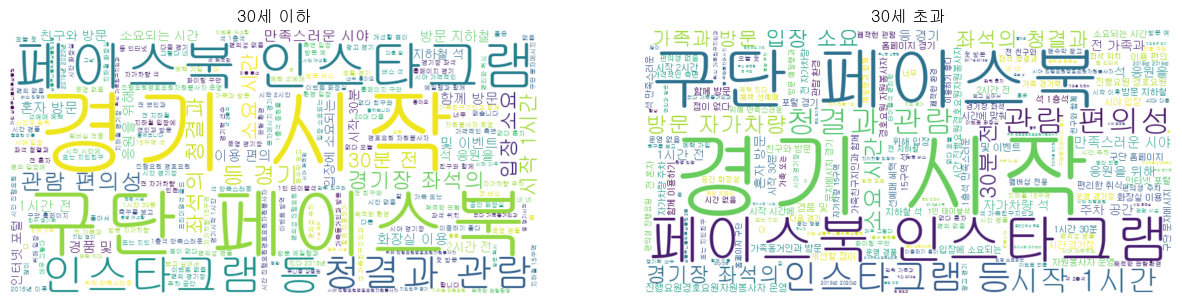

In [ ]:
excluded_indices = df_svym.index
df_remaining = df_svy[~df_svy.index.isin(excluded_indices)]

def preprocess_text(text):
  if not isinstance(text, str):
    return ''
  text = re.sub(r'[^가-힣0-9\s]', '', text)
  return text

# 30세 이하와 30세 초과로 데이터프레임 나누기
df_under_30 = df_remaining[df_remaining['age'] <= 30]
df_over_30 = df_remaining[df_remaining['age'] > 30]

df_under_30.loc[:, 'processed_content'] = df_under_30['answer_content'].apply(preprocess_text)
df_over_30.loc[:, 'processed_content'] = df_over_30['answer_content'].apply(preprocess_text)

# 30세 이하 워드클라우드 생성
text_under_30 = ' '.join(df_under_30['processed_content'])
wordcloud_under_30 = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text_under_30)

# 30세 초과 워드클라우드 생성
text_over_30 = ' '.join(df_over_30['processed_content'])
wordcloud_over_30 = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text_over_30)

plt.figure(figsize=(15, 7))

# 30세 이하
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_under_30, interpolation='bilinear')
plt.axis('off')
plt.title('30세 이하')

# 30세 초과
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_over_30, interpolation='bilinear')
plt.axis('off')
plt.title('30세 초과')

plt.show()

In [ ]:
# 30세 이하와 30세 초과의 수 계산
under_30_count = df_remaining[df_remaining['age'] <= 30].shape[0]
over_30_count = df_remaining[df_remaining['age'] > 30].shape[0]

print(f"30세 이하 수: {under_30_count}")
print(f"30세 초과 수: {over_30_count}")

30세 이하 수: 22016
30세 초과 수: 44377


In [ ]:
from collections import Counter

# 30세 이하 단어 빈도 계산
under_30_words = ' '.join(df_under_30['processed_content']).split()
under_30_word_counts = Counter(under_30_words)
top_20_under_30 = under_30_word_counts.most_common(20)

# 30세 초과 단어 빈도 계산
over_30_words = ' '.join(df_over_30['processed_content']).split()
over_30_word_counts = Counter(over_30_words)
top_20_over_30 = over_30_word_counts.most_common(20)

print("30세 이하 상위 20개 단어:")
for word, count in top_20_under_30:
    print(f"{word}: {count}")

print("\n30세 초과 상위 20개 단어:")
for word, count in top_20_over_30:
    print(f"{word}: {count}")

30세 이하 상위 20개 단어:
방문: 1728
경기: 1646
시작: 1397
전: 1313
구단: 1260
등: 975
석: 952
경기장: 933
시간: 922
페이스북: 907
인스타그램: 907
관람: 889
없음: 791
편의성: 751
청결과: 718
1시간: 713
지하철: 680
좌석의: 674
입장: 637
운영: 633

30세 초과 상위 20개 단어:
방문: 3398
경기: 3320
시작: 2891
전: 2597
구단: 2482
석: 2019
자가차량: 1912
경기장: 1744
시간: 1741
관람: 1708
없음: 1683
등: 1472
1시간: 1433
편의성: 1386
30분: 1362
입장: 1342
인스타그램: 1333
페이스북: 1324
청결과: 1316
운영: 1274


In [ ]:
# 'ALL_CANCEL'과 'PART_CANCEL'을 'CANCEL'로 통합
df_2022.loc[df_2022['reserve_state_code'].isin(['ALL_CANCEL', 'PART_CANCEL']), 'reserve_state_code'] = 'CANCEL'

# ALL_CANCEL 또는 PART_CANCEL이 있는 예약취소 행을 추출
df_can = df_2022[df_2022['reserve_state_code'] == 'CANCEL'].copy()

# 취소된 COMPLETE 예약을 EXCEPT 값으로 변경
df_2022.loc[
    (df_2022['reserve_state_code'] == 'COMPLETE') &
    (df_2022.set_index(['game_date', 'membership_no', 'reserve_detail_no']).index.isin(
        df_can.set_index(['game_date', 'membership_no', 'reserve_detail_no']).index
    )),
    'reserve_state_code'
] = 'EXCEPT'

# COMPLETE 와 CANCEL 을 비교하기위한 데이터 생성
df_org = df_2022[df_2022['reserve_state_code'] != 'EXCEPT'].copy()
df_org2 = df_org[df_org['reserve_state_code'] != 'CANCEL']

In [ ]:
df_org1 = df_org[df_org['reserve_state_code'] != 'CANCEL'][['membership_no', 'game_date', 'reserve_state_code', 'reserve_detail_no', 'score']].copy()
df_org1 = df_org1.drop(columns=['reserve_state_code'])

grouped_df = df_org.groupby(['membership_no', 'game_date', 'score']).size().reset_index(name='ticket_count')

# 지난 경기 전적 추가
grouped_df['last_game'] = grouped_df.groupby('membership_no')['score'].shift(1)

# last_game이 결측값인 행 삭제
grouped_df = grouped_df.dropna(subset=['last_game'])

# df_org1에 last_game 열 추가하기 위한 merge
df_merged = pd.merge(df_org, grouped_df[['membership_no', 'game_date', 'last_game']], on=['membership_no', 'game_date'], how='left')
# last_game 열의 결측값이 있는 행 삭제
df_merged = df_merged.dropna(subset=['last_game'])

df_merged

,membership_no,job,favorite_idx,age,지점명,game_date,최고기온(°C),일강수량(mm),yoil,field_name,audience,score,game_time,reserve_state_code,reserve_detail_no,product_grade_name,product_denomination_name,last_game
3,153,프리랜서,김도혁,63,인천,2022-02-26,7.0,0.5,토,인천,4618.0,0.0,14:00:00,COMPLETE,1.0,NSE석,성인(할인),1.0
4,153,프리랜서,김도혁,63,인천,2022-03-05,5.2,0.0,토,인천,3581.0,-1.0,19:00:00,COMPLETE,1.0,NSE석,성인,0.0
5,153,프리랜서,김도혁,63,인천,2022-03-13,11.8,32.8,일,인천,2607.0,1.0,14:00:00,COMPLETE,1.0,NSE석,성인,-1.0
6,153,프리랜서,김도혁,63,인천,2022-04-10,21.5,0.0,일,인천,5234.0,0.0,16:30:00,COMPLETE,1.0,NSE석,성인,1.0
7,153,프리랜서,김도혁,63,인천,2022-05-29,24.9,0.0,일,인천,6119.0,1.0,16:30:00,COMPLETE,1.0,NSE석,성인,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48821,151757,회사원,송시우,37,인천,2022-10-16,19.2,0.0,일,인천,7592.0,0.0,19:00:00,CANCEL,3.0,테이블석,성인,1.0
48822,151757,회사원,송시우,37,인천,2022-10-16,19.2,0.0,일,인천,7592.0,0.0,19:00:00,CANCEL,4.0,테이블석,성인,1.0
48823,151757,회사원,송시우,37,인천,2022-10-16,19.2,0.0,일,인천,7592.0,0.0,19:00:00,COMPLETE,5.0,테이블석,성인,1.0
48824,151757,회사원,송시우,37,인천,2022-10-16,19.2,0.0,일,인천,7592.0,0.0,19:00:00,COMPLETE,6.0,테이블석,성인,1.0


<ipython-input-129-a5836e112227>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_counts.index, y=job_counts.values, palette='Set2', edgecolor='black')


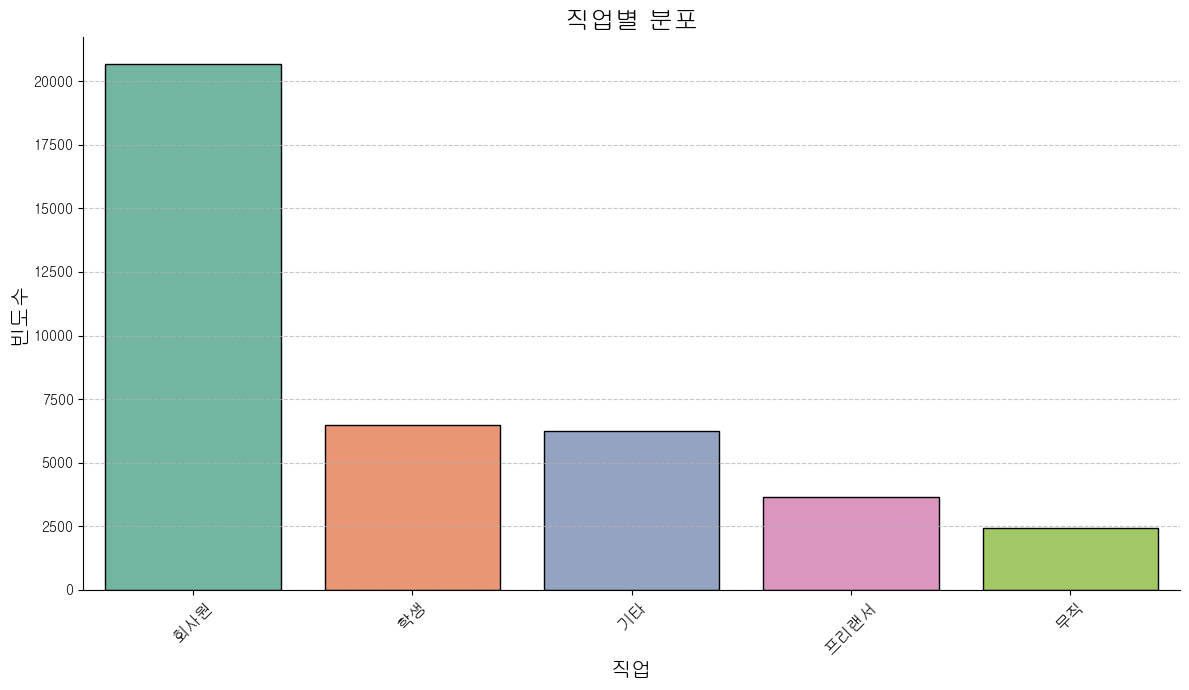

In [ ]:
job_counts = df_org2['job'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=job_counts.index, y=job_counts.values, palette='Set2', edgecolor='black')

plt.title('직업별 분포', fontsize=18, fontweight='bold')
plt.xlabel('직업', fontsize=15, fontweight='bold')
plt.ylabel('빈도수', fontsize=15, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-131-27be0bf6fafb>:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


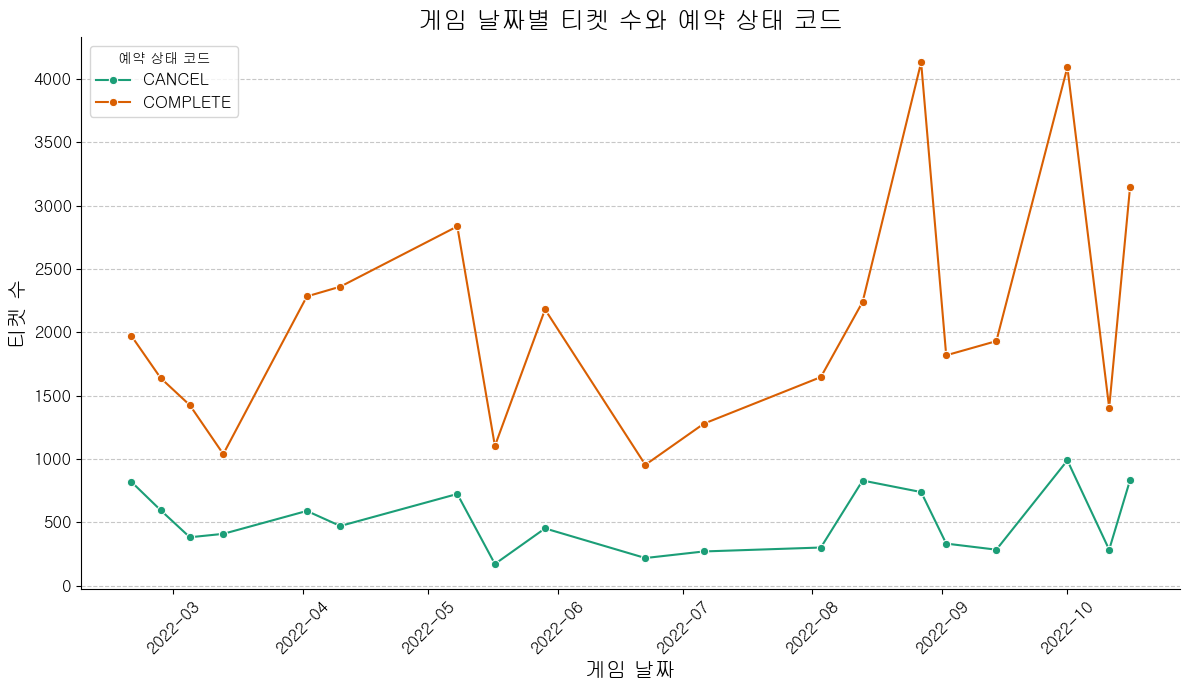

In [ ]:
df_counts = df_org.groupby(['game_date', 'reserve_state_code']).size().reset_index(name='counts')
df_sorted = df_counts.sort_values('game_date', ascending=True)

plt.figure(figsize=(12, 7), layout='constrained')
sns.lineplot(data=df_sorted, x='game_date', y='counts', hue='reserve_state_code', palette='Dark2', marker='o')

# 그래프 설정
sns.despine()
plt.xlabel('게임 날짜', fontsize=15, fontweight='bold')
plt.ylabel('티켓 수', fontsize=15, fontweight='bold')
plt.title('게임 날짜별 티켓 수와 예약 상태 코드', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='예약 상태 코드', fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-132-44f62549056a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=last_game_counts, x='last_game', y='count', palette='viridis')


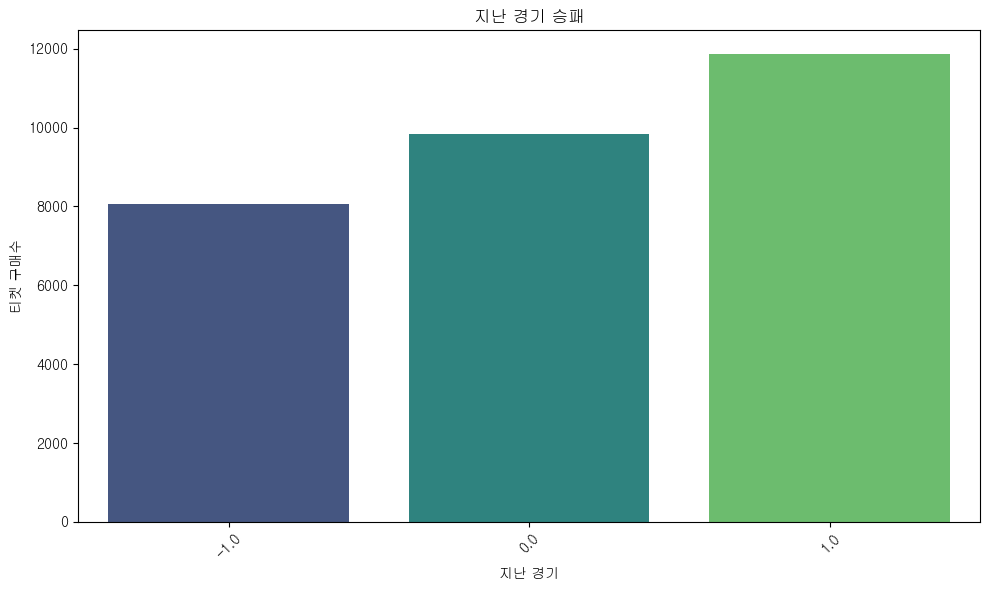

In [ ]:
# last_game 열의 빈도수 계산
last_game_counts = df_merged['last_game'].value_counts().reset_index()
last_game_counts.columns = ['last_game', 'count']

# 바 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(data=last_game_counts, x='last_game', y='count', palette='viridis')

# 그래프 레이블 및 타이틀 설정
plt.xlabel('지난 경기')
plt.ylabel('티켓 구매수')
plt.title('지난 경기 승패')
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 보여주기
plt.show()

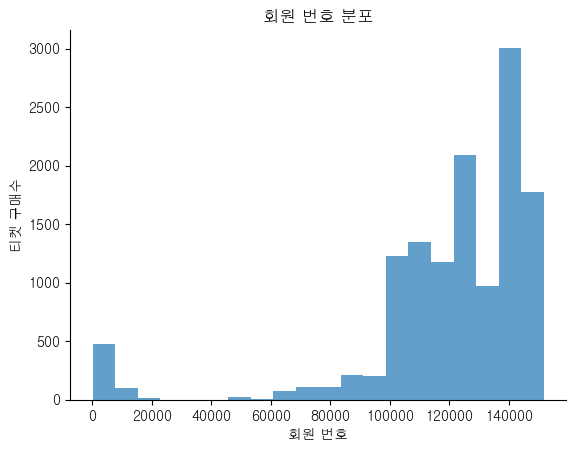

In [ ]:
# 회원 번호 분포 그래프
ax = grouped_df['membership_no'].plot(kind='hist', bins=20, title='회원 번호 분포', alpha=0.7)
ax.set_ylabel('티켓 구매수')
ax.set_xlabel('회원 번호')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

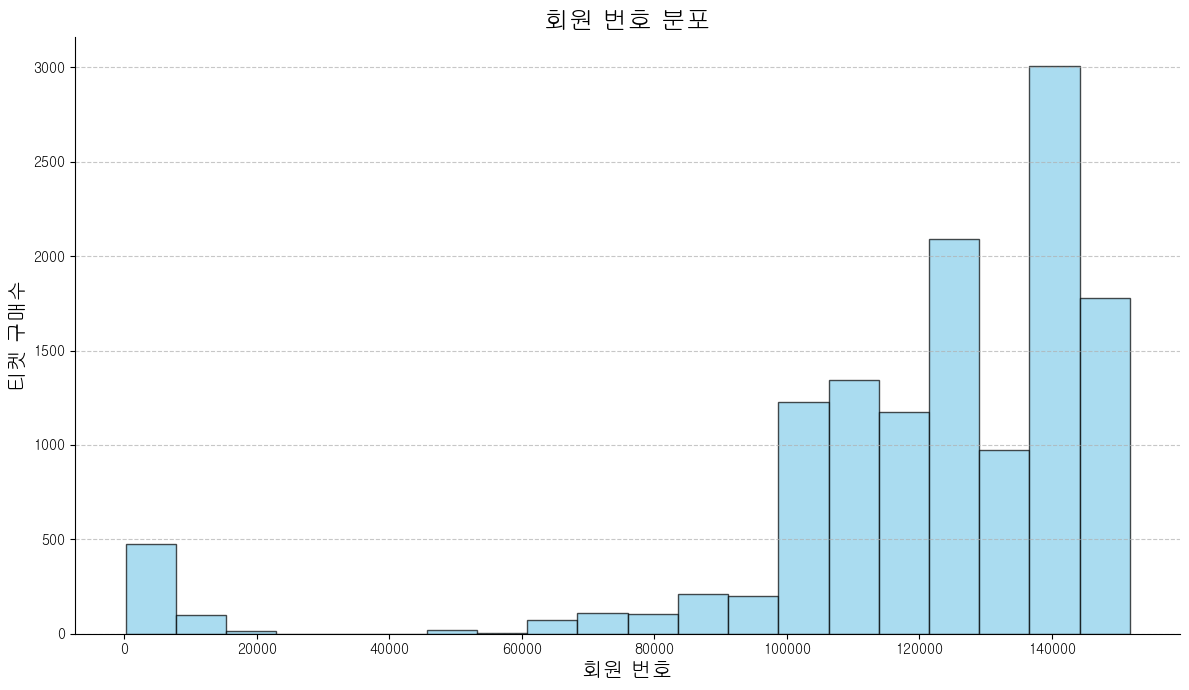

In [ ]:
# 회원 번호 분포 그래프
plt.figure(figsize=(12, 7))
ax = grouped_df['membership_no'].plot(kind='hist', bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax.set_title('회원 번호 분포', fontsize=18, fontweight='bold')
ax.set_ylabel('티켓 구매수', fontsize=15, fontweight='bold')
ax.set_xlabel('회원 번호', fontsize=15, fontweight='bold')

plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

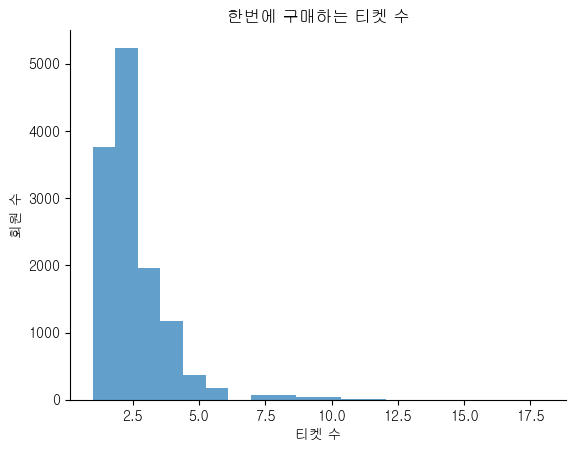

In [ ]:
ax = grouped_df['ticket_count'].plot(kind='hist', bins=20, title='한번에 구매하는 티켓 수', alpha=0.7)
ax.set_ylabel('회원 수')
ax.set_xlabel('티켓 수')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

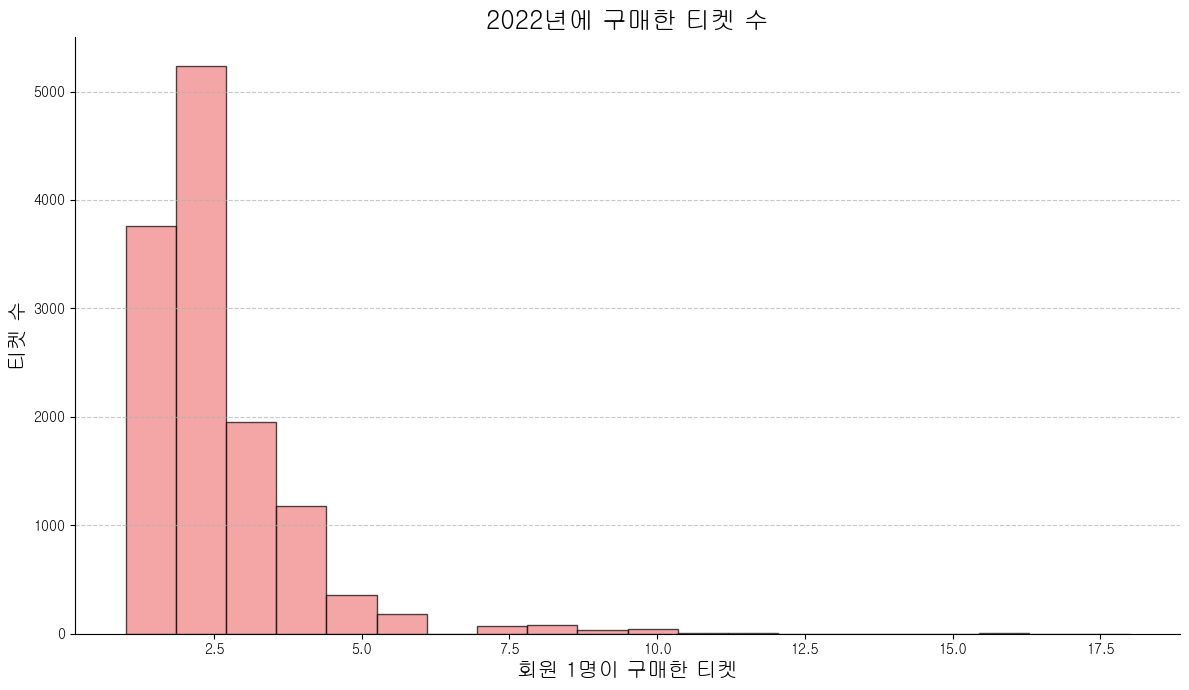

In [ ]:
plt.figure(figsize=(12, 7))
ax = grouped_df['ticket_count'].plot(kind='hist', bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
ax.set_title('2022년에 구매한 티켓 수', fontsize=18, fontweight='bold')
ax.set_ylabel('티켓 수', fontsize=15, fontweight='bold')
ax.set_xlabel('회원 1명이 구매한 티켓', fontsize=15, fontweight='bold')

plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

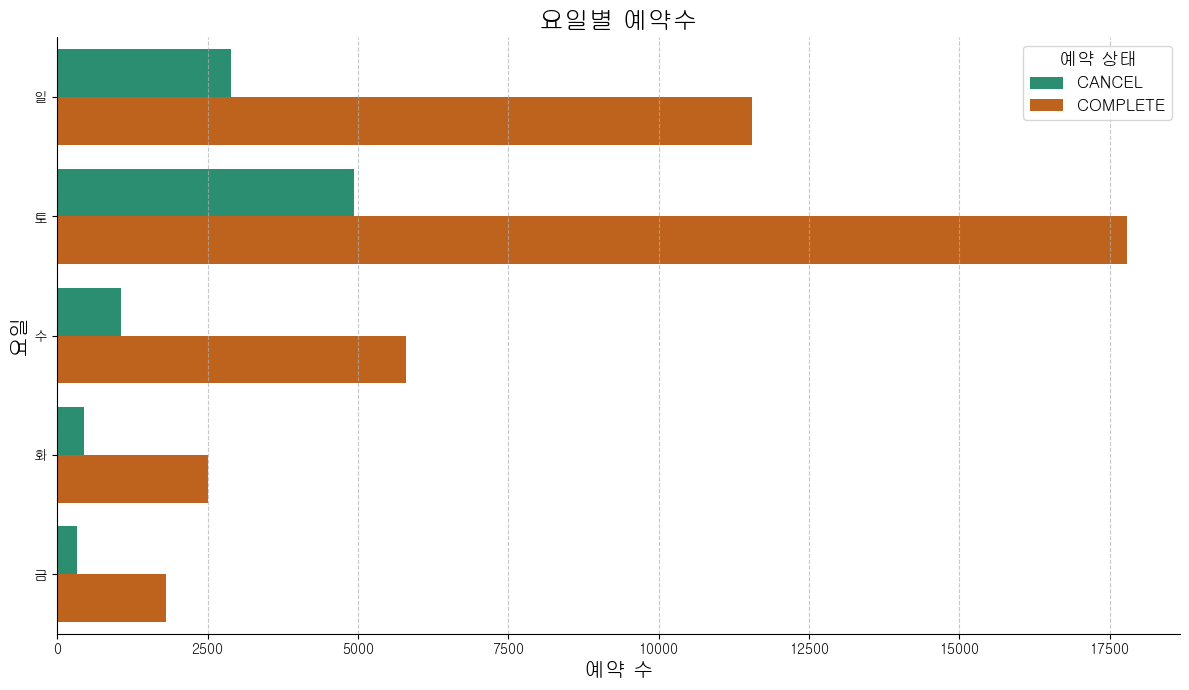

In [ ]:

plt.figure(figsize=(12, 7))
sns.countplot(data=df_org, y='yoil', hue='reserve_state_code', palette='Dark2')

plt.title('요일별 예약수', fontsize=18, fontweight='bold')
plt.xlabel('예약 수', fontsize=15, fontweight='bold')
plt.ylabel('요일', fontsize=15, fontweight='bold')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(title='예약 상태', fontsize=12, title_fontsize='13')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

reserve_state_code yoil  complete_ratio  cancel_ratio
0                     금       84.597487     15.402513
1                     수       84.453170     15.546830
2                     일       80.029074     19.970926
3                     토       78.262400     21.737600
4                     화       84.690774     15.309226


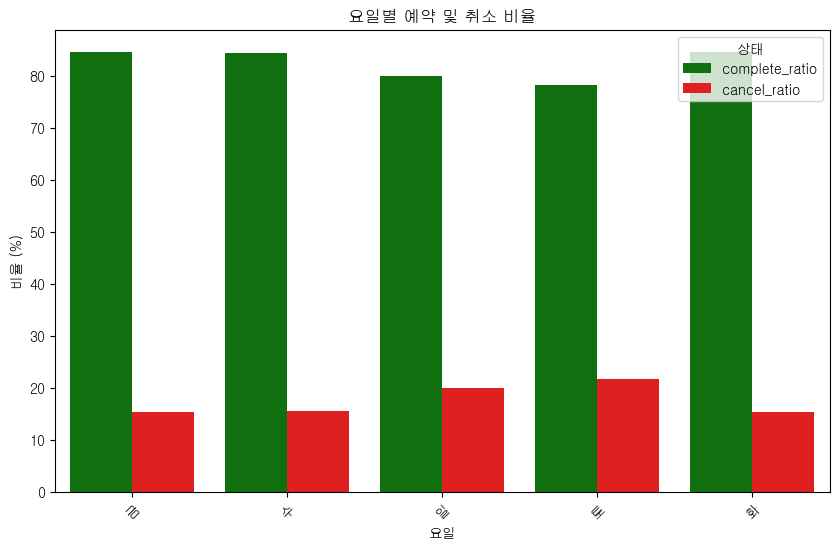

In [ ]:
summary = df_org.groupby(['yoil', 'reserve_state_code']).size().reset_index(name='count')

# COMPLETE와 CANCEL의 비율 계산
summary_pivot = summary.pivot(index='yoil', columns='reserve_state_code', values='count').fillna(0)
summary_pivot['total'] = summary_pivot.sum(axis=1)
summary_pivot['complete_ratio'] = summary_pivot['COMPLETE'] / summary_pivot['total'] * 100
summary_pivot['cancel_ratio'] = summary_pivot['CANCEL'] / summary_pivot['total'] * 100

ratio_df = summary_pivot[['complete_ratio', 'cancel_ratio']].reset_index()

print(ratio_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=ratio_df.melt(id_vars='yoil', value_vars=['complete_ratio', 'cancel_ratio'],
                                 var_name='status', value_name='ratio'),
             x='yoil', y='ratio', hue='status', palette=['green', 'red'])

plt.title('요일별 예약 및 취소 비율')
plt.xlabel('요일')
plt.ylabel('비율 (%)')
plt.legend(title='상태')
plt.xticks(rotation=45)
plt.show()

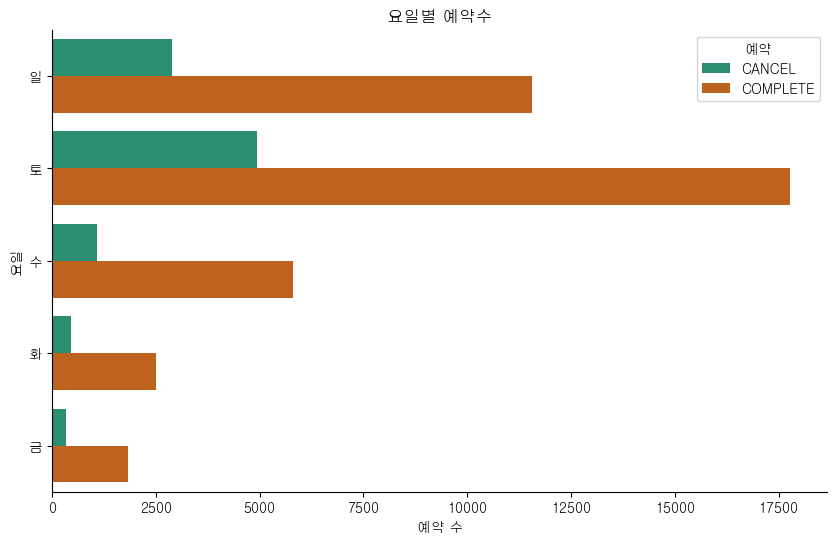

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_org, y='yoil', hue='reserve_state_code', palette='Dark2')

# 그래프의 상단과 오른쪽 테두리 숨기기
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('요일별 예약수')
plt.xlabel('예약 수')
plt.ylabel('요일')
plt.legend(title='예약')
plt.show()

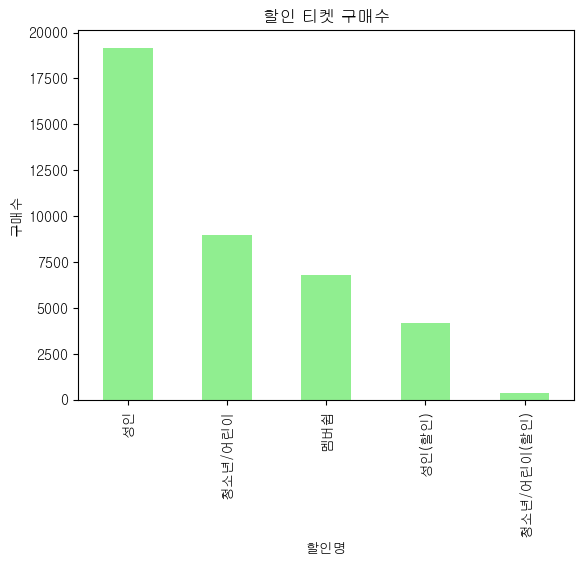

In [ ]:
# 'product_denomination_name' 열의 값 개수 세기
denomination_counts = df_org2['product_denomination_name'].value_counts()
denomination_counts.plot(kind='bar', color='lightgreen', title='할인 티켓 구매수')

plt.xlabel('할인명')
plt.ylabel('구매수')
plt.show()

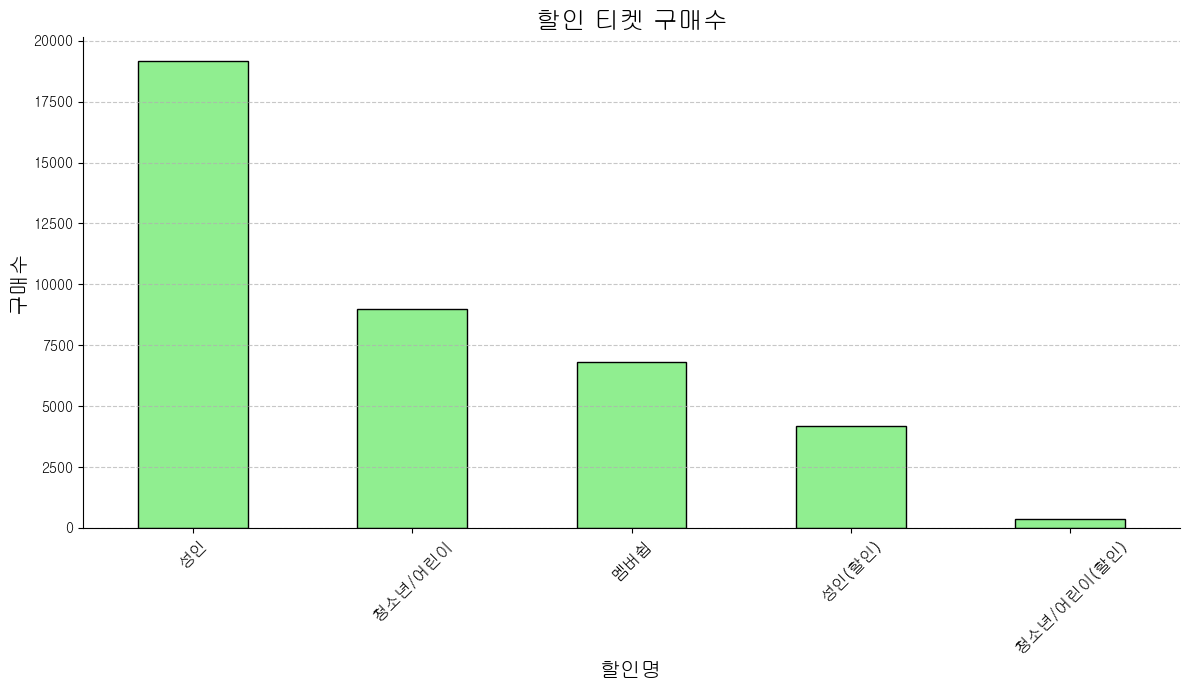

In [ ]:
# 'product_denomination_name' 열의 값 개수 세기
denomination_counts = df_org2['product_denomination_name'].value_counts()

plt.figure(figsize=(12, 7))
denomination_counts.plot(kind='bar', color='lightgreen', edgecolor='black')


plt.title('할인 티켓 구매수', fontsize=18, fontweight='bold')
plt.xlabel('할인명', fontsize=15, fontweight='bold')
plt.ylabel('구매수', fontsize=15, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

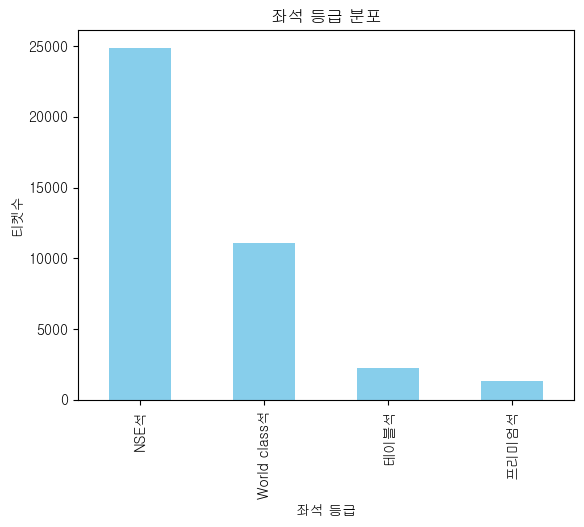

In [ ]:
# 'product_grade_name' 열의 값 개수 세기
grade_counts = df_org2['product_grade_name'].value_counts()
grade_counts.plot(kind='bar', color='skyblue', title='좌석 등급 분포')

plt.xlabel('좌석 등급')
plt.ylabel('티켓수')
plt.show()

In [ ]:
mapping = {
    '프리미엄석': 35000,
    '테이블석': 22500,
    'World class석': 19000,
    'NSE석': 12000
}


df_seat = df_org2.copy()
df_seat['value'] = df_seat['product_grade_name'].map(mapping)


average_value = df_seat['value'].mean()
print("평균 값:", average_value)

평균 값: 15312.268835182653


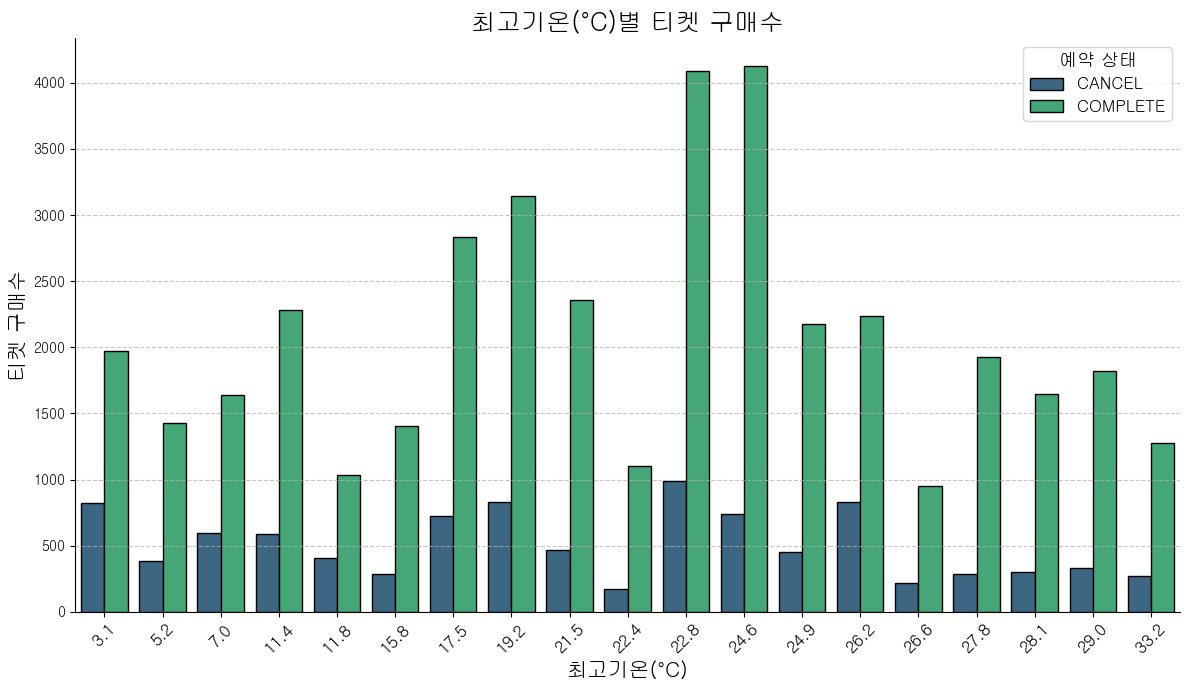

In [ ]:
# 데이터프레임을 최고기온(°C)와 reserve_state_code로 그룹화하고 빈도수 추가
grouped_data = df_org.groupby(['최고기온(°C)', 'reserve_state_code']).size().reset_index(name='빈도수')

plt.figure(figsize=(12, 7))
sns.barplot(data=grouped_data, x='최고기온(°C)', y='빈도수', hue='reserve_state_code', palette='viridis', edgecolor='black')
plt.xlabel('최고기온(°C)', fontsize=15, fontweight='bold')
plt.ylabel('티켓 구매수', fontsize=15, fontweight='bold')
plt.title('최고기온(°C)별 티켓 구매수', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='예약 상태', fontsize=12, title_fontsize='13')
plt.tight_layout()
plt.show()

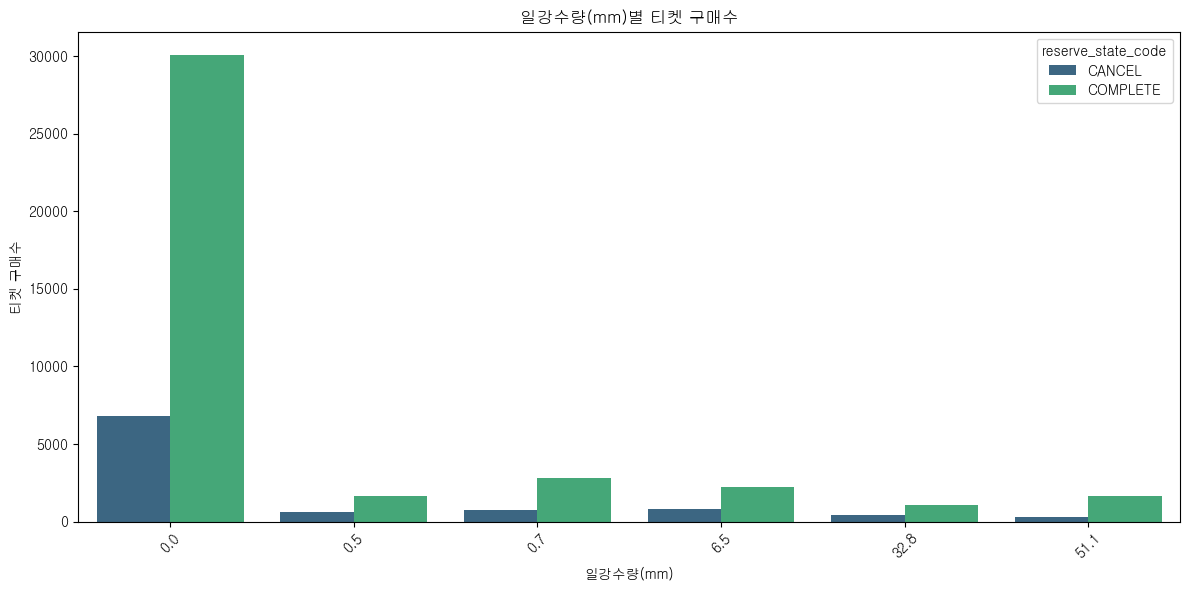

In [ ]:
# 데이터프레임을 일강수량(mm)	와 reserve_state_code로 그룹화하고 빈도수 추가
grouped_data = df_org.groupby(['일강수량(mm)', 'reserve_state_code']).size().reset_index(name='빈도수')

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, x='일강수량(mm)', y='빈도수', hue='reserve_state_code', palette='viridis')

plt.xlabel('일강수량(mm)')
plt.ylabel('티켓 구매수')
plt.title('일강수량(mm)별 티켓 구매수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()